In [ ]:
#Train and save the model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 16 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Initialize model, loss, and optimizer
model = LeNet5()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train model
num_epochs = 5
for epoch in range(num_epochs):
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

#Save the trained model to extract weights later
torch.save(model.state_dict(), "lenet5_mnist.pth")
print("Model trained and saved as lenet5_mnist.pth")

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.25MB/s]


Epoch [1/5], Loss: 0.0606
Epoch [2/5], Loss: 0.0308
Epoch [3/5], Loss: 0.1241
Epoch [4/5], Loss: 0.0117
Epoch [5/5], Loss: 0.0023
Model trained and saved as lenet5_mnist.pth


In [ ]:
#Test the Model's performance against the Test Dataset

import torch
import torchvision
import torchvision.transforms as transforms

model = LeNet5()
model.load_state_dict(torch.load("lenet5_mnist.pth", map_location=torch.device('cpu')))
model.eval()

transform = transforms.Compose([transforms.ToTensor()])
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

def test_accuracy(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Consider the class with highest probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

test_accuracy(model, testloader)

Test Accuracy: 98.31%


In [ ]:
# Store the Model's weights from each layer in Binary/Text format
# These files will be used in our C program later when we are implementing the model using C and CUDA

import torch
import torch.nn as nn
import numpy as np

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)  # (6, 1, 5, 5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)  # (16, 6, 5, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # (120, 256)
        self.fc2 = nn.Linear(120, 84)  # (84, 120)
        self.fc3 = nn.Linear(84, 10)  # (10, 84)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 16 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet5()
model.load_state_dict(torch.load("lenet5_mnist.pth", map_location=torch.device('cpu')))
model.eval()

# Function to save weights to a text file
def save_weights_txt(model, filename="weights.txt"):
    with open(filename, "w") as f:
        for name, param in model.named_parameters():
            f.write(f"{name} {param.numel()} ")  # Store layer name and size
            np.savetxt(f, param.detach().numpy().flatten(), fmt="%.6f")  # Save weights

# Function to save weights in a binary file
def save_weights_bin(model, filename="weights.bin"):
    with open(filename, "wb") as f:
        for name, param in model.named_parameters():
            np.array([param.numel()], dtype=np.int32).tofile(f)  # Store size
            param.detach().numpy().flatten().astype(np.float32).tofile(f)  # Store weights

save_weights_txt(model, "weights.txt")
save_weights_bin(model, "weights.bin")

The below code is to compare the conv1 outputs from C implementation and CUDA implementation

In [ ]:
import numpy as np

def load_output(filename, num_filters=6, height=24, width=24):
    outputs = []
    with open(filename, 'r') as f:
        current_filter = []
        for line in f:
            if line.strip() == "":
                if current_filter:
                    outputs.append(np.array(current_filter))
                    current_filter = []
            else:
                current_filter.append([float(val) for val in line.strip().split()])
        if current_filter:
            outputs.append(np.array(current_filter))  # handle last filter
    return np.array(outputs).reshape((num_filters, height, width))

def compare_outputs(cpu_file, cuda_file, tolerance=1e-5):
    cpu_output = load_output(cpu_file)
    cuda_output = load_output(cuda_file)

    if cpu_output.shape != cuda_output.shape:
        print(f"Shape mismatch: CPU {cpu_output.shape} vs CUDA {cuda_output.shape}")
        return

    diff = np.abs(cpu_output - cuda_output)
    max_diff = np.max(diff)
    mean_diff = np.mean(diff)

    print(f"Max difference: {max_diff:.6e}")
    print(f"Mean difference: {mean_diff:.6e}")

    if np.all(diff < tolerance):
        print("✅ Outputs match within tolerance.")
    else:
        print("❌ Outputs differ beyond tolerance.")
        mismatches = np.argwhere(diff >= tolerance)
        print(f"{len(mismatches)} values exceed tolerance of {tolerance}. Example mismatch:")
        for idx in mismatches[:5]:
            f, i, j = idx
            print(f"Filter {f}, Row {i}, Col {j}: CPU={cpu_output[f][i][j]:.6f}, CUDA={cuda_output[f][i][j]:.6f}, Δ={diff[f][i][j]:.6e}")

# Run the comparison
compare_outputs("conv1_output.txt", "conv1_cuda_output.txt")

Max difference: 2.000000e-06
Mean difference: 1.073495e-07
✅ Outputs match within tolerance.


Code to compare the Pool1 layer outputs

In [ ]:
import numpy as np

def load_output(filename, num_filters=6, height=12, width=12):
    outputs = []
    with open(filename, 'r') as f:
        current_filter = []
        for line in f:
            if line.strip() == "":
                if current_filter:
                    outputs.append(np.array(current_filter))
                    current_filter = []
            else:
                current_filter.append([float(val) for val in line.strip().split()])
        if current_filter:
            outputs.append(np.array(current_filter))  # catch last filter
    return np.array(outputs).reshape((num_filters, height, width))

def compare_outputs(cpu_file, cuda_file, tolerance=1e-5):
    cpu_output = load_output(cpu_file)
    cuda_output = load_output(cuda_file)

    if cpu_output.shape != cuda_output.shape:
        print(f"Shape mismatch: CPU {cpu_output.shape} vs CUDA {cuda_output.shape}")
        return

    diff = np.abs(cpu_output - cuda_output)
    max_diff = np.max(diff)
    mean_diff = np.mean(diff)

    print(f"Max difference: {max_diff:.6e}")
    print(f"Mean difference: {mean_diff:.6e}")

    if np.all(diff < tolerance):
        print("✅ Pool1 outputs match within tolerance.")
    else:
        print("❌ Pool1 outputs differ beyond tolerance.")
        mismatches = np.argwhere(diff >= tolerance)
        print(f"{len(mismatches)} mismatches found (tolerance {tolerance}).")
        for idx in mismatches[:5]:
            f, i, j = idx
            print(f"Filter {f}, Row {i}, Col {j}: CPU={cpu_output[f][i][j]:.6f}, CUDA={cuda_output[f][i][j]:.6f}, Δ={diff[f][i][j]:.6e}")

# Run the comparison
compare_outputs("pool1_output.txt", "pool1_cuda_output.txt")

Max difference: 1.000000e-06
Mean difference: 1.400463e-07
✅ Pool1 outputs match within tolerance.


Code to compare the Conv2 layer outputs

In [ ]:
import numpy as np

def load_output(filename, num_filters=16, height=8, width=8):
    outputs = []
    with open(filename, 'r') as f:
        current_filter = []
        for line in f:
            if line.strip() == "":
                if current_filter:
                    outputs.append(np.array(current_filter))
                    current_filter = []
            else:
                current_filter.append([float(val) for val in line.strip().split()])
        if current_filter:
            outputs.append(np.array(current_filter))  # handle last block
    return np.array(outputs).reshape((num_filters, height, width))

def compare_outputs(cpu_file, cuda_file, tolerance=1e-5):
    cpu_output = load_output(cpu_file)
    cuda_output = load_output(cuda_file)

    if cpu_output.shape != cuda_output.shape:
        print(f"Shape mismatch: CPU {cpu_output.shape} vs CUDA {cuda_output.shape}")
        return

    diff = np.abs(cpu_output - cuda_output)
    max_diff = np.max(diff)
    mean_diff = np.mean(diff)

    print(f"Max difference: {max_diff:.6e}")
    print(f"Mean difference: {mean_diff:.6e}")

    if np.all(diff < tolerance):
        print("✅ Conv2 outputs match within tolerance.")
    else:
        print("❌ Conv2 outputs differ beyond tolerance.")
        mismatches = np.argwhere(diff >= tolerance)
        print(f"{len(mismatches)} mismatches (tolerance {tolerance}). Showing first few:")
        for idx in mismatches[:5]:
            f, i, j = idx
            print(f"Filter {f}, Row {i}, Col {j}: CPU={cpu_output[f][i][j]:.6f}, CUDA={cuda_output[f][i][j]:.6f}, Δ={diff[f][i][j]:.6e}")

# Run it
compare_outputs("conv2_output.txt", "conv2_cuda_output.txt")

Max difference: 3.000000e-06
Mean difference: 1.806641e-07
✅ Conv2 outputs match within tolerance.


Code to compare the Pool2 layer outputs

In [ ]:
import numpy as np

def load_output(filename, num_filters=16, height=4, width=4):
    outputs = []
    with open(filename, 'r') as f:
        current_filter = []
        for line in f:
            if line.strip() == "":
                if current_filter:
                    outputs.append(np.array(current_filter))
                    current_filter = []
            else:
                current_filter.append([float(val) for val in line.strip().split()])
        if current_filter:
            outputs.append(np.array(current_filter))
    return np.array(outputs).reshape((num_filters, height, width))

def compare_outputs(cpu_file, cuda_file, tolerance=1e-5):
    cpu_output = load_output(cpu_file)
    cuda_output = load_output(cuda_file)

    if cpu_output.shape != cuda_output.shape:
        print(f"Shape mismatch: CPU {cpu_output.shape} vs CUDA {cuda_output.shape}")
        return

    diff = np.abs(cpu_output - cuda_output)
    max_diff = np.max(diff)
    mean_diff = np.mean(diff)

    print(f"Max difference: {max_diff:.6e}")
    print(f"Mean difference: {mean_diff:.6e}")

    if np.all(diff < tolerance):
        print("✅ Pool2 outputs match within tolerance.")
    else:
        print("❌ Pool2 outputs differ beyond tolerance.")
        mismatches = np.argwhere(diff >= tolerance)
        print(f"{len(mismatches)} mismatches found (tolerance {tolerance}). Showing up to 5:")
        for idx in mismatches[:5]:
            f, i, j = idx
            print(f"Filter {f}, Row {i}, Col {j}: CPU={cpu_output[f][i][j]:.6f}, CUDA={cuda_output[f][i][j]:.6f}, Δ={diff[f][i][j]:.6e}")

# Run the comparison
compare_outputs("pool2_output.txt", "pool2_cuda_output.txt")

Max difference: 3.000000e-06
Mean difference: 3.203125e-07
✅ Pool2 outputs match within tolerance.


Code to compare the FC1 layer outputs

In [ ]:
import numpy as np

def compare_fc1_outputs(cuda_file, c_file, tolerance=1e-5):
    cuda_output = np.loadtxt(cuda_file)
    c_output = np.loadtxt(c_file)

    if cuda_output.shape != c_output.shape:
        print("❌ Shape mismatch:")
        print(f"  CUDA: {cuda_output.shape}, C: {c_output.shape}")
        return

    diff = np.abs(cuda_output - c_output)
    max_diff = np.max(diff)
    mean_diff = np.mean(diff)

    print(f"✅ Shape matched: {cuda_output.shape}")
    print(f"🔍 Max difference: {max_diff:.6e}")
    print(f"📉 Mean difference: {mean_diff:.6e}")

    if np.all(diff < tolerance):
        print("✅ FC1 outputs match within the tolerance.")
    else:
        print("⚠️ FC1 outputs differ at some positions.")
        # Show a few mismatches
        mismatches = np.where(diff >= tolerance)[0]
        for idx in mismatches[:5]:  # Show up to 5 mismatches
            print(f"  Index {idx}: CUDA={cuda_output[idx]:.6f}, C={c_output[idx]:.6f}, Δ={diff[idx]:.6e}")

# Run the comparison
compare_fc1_outputs("fc1_cuda_output.txt", "fc1_output.txt")

✅ Shape matched: (120,)
🔍 Max difference: 2.000000e-06
📉 Mean difference: 2.666667e-07
✅ FC1 outputs match within the tolerance.


Code to compare FC2 outputs

In [ ]:
import numpy as np

def compare_fc2_outputs(cuda_file, c_file, tolerance=1e-5):
    # Load outputs as 1-D arrays
    cuda_output = np.loadtxt(cuda_file)
    c_output = np.loadtxt(c_file)

    # Check if shapes match
    if cuda_output.shape != c_output.shape:
        print("Shape mismatch:")
        print(f"  CUDA output shape: {cuda_output.shape}")
        print(f"  C output shape: {c_output.shape}")
        return

    # Calculate difference
    diff = np.abs(cuda_output - c_output)
    max_diff = np.max(diff)
    mean_diff = np.mean(diff)

    print(f"Max difference: {max_diff:.6e}")
    print(f"Mean difference: {mean_diff:.6e}")

    if np.all(diff < tolerance):
        print("✅ FC2 outputs match within the tolerance.")
    else:
        print("❌ FC2 outputs differ beyond the tolerance.")
        indices = np.where(diff >= tolerance)[0]
        print(f"Mismatch found at {len(indices)} indices (showing up to 5):")
        for idx in indices[:5]:
            print(f"  Index {idx}: CUDA = {cuda_output[idx]:.6f}, C = {c_output[idx]:.6f}, Diff = {diff[idx]:.6e}")

# Run the comparison
compare_fc2_outputs("fc2_cuda_output.txt", "fc2_output.txt")

Max difference: 3.000000e-06
Mean difference: 3.095238e-07
✅ FC2 outputs match within the tolerance.


Code to compare FC3 outputs

In [ ]:
import numpy as np

def compare_fc3_outputs(cuda_file, c_file, tolerance=1e-5):
    # Load outputs as 1-D arrays
    cuda_output = np.loadtxt(cuda_file)
    c_output = np.loadtxt(c_file)

    # Check if shapes match
    if cuda_output.shape != c_output.shape:
        print("Shape mismatch:")
        print(f"  CUDA output shape: {cuda_output.shape}")
        print(f"  C output shape: {c_output.shape}")
        return

    # Calculate difference
    diff = np.abs(cuda_output - c_output)
    max_diff = np.max(diff)
    mean_diff = np.mean(diff)

    print(f"Max difference: {max_diff:.6e}")
    print(f"Mean difference: {mean_diff:.6e}")

    if np.all(diff < tolerance):
        print("✅ FC2 outputs match within the tolerance.")
    else:
        print("❌ FC2 outputs differ beyond the tolerance.")
        indices = np.where(diff >= tolerance)[0]
        print(f"Mismatch found at {len(indices)} indices (showing up to 5):")
        for idx in indices[:5]:
            print(f"  Index {idx}: CUDA = {cuda_output[idx]:.6f}, C = {c_output[idx]:.6f}, Diff = {diff[idx]:.6e}")

# Run the comparison
compare_fc3_outputs("fc3_cuda_output.txt", "fc3_output.txt")

Max difference: 3.000000e-06
Mean difference: 1.000000e-06
✅ FC2 outputs match within the tolerance.


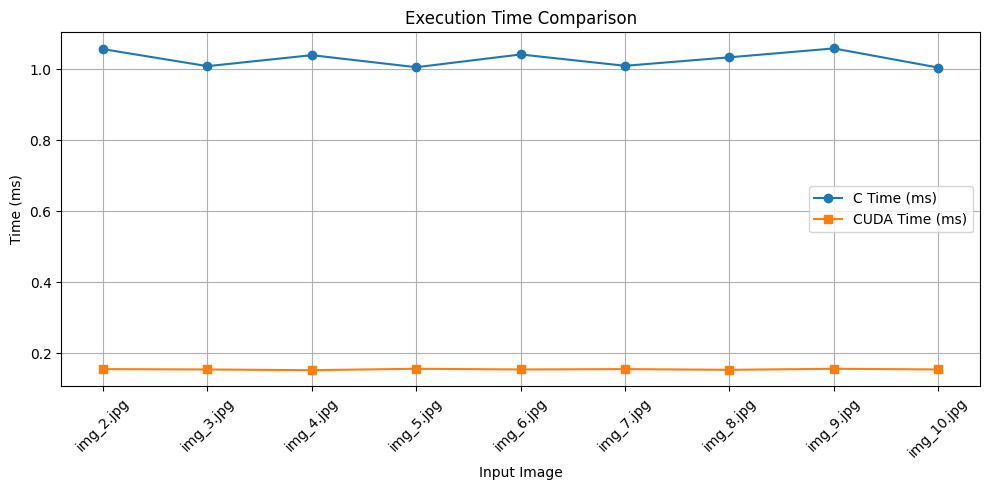

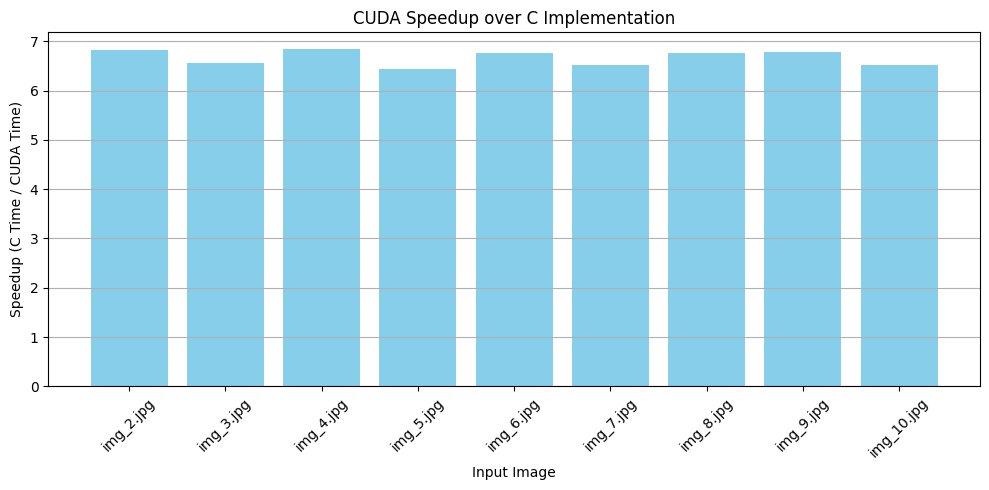

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
data = {
    "Image": [f"img_{i}.jpg" for i in range(2, 11)],
    "C_Time": [1.057, 1.009, 1.04, 1.006, 1.042, 1.01, 1.034, 1.059, 1.005],
    "CUDA_Time": [0.155, 0.154, 0.152, 0.156, 0.154, 0.155, 0.153, 0.156, 0.154],
}

# DataFrame and speedup calculation
df = pd.DataFrame(data)
df["Speedup"] = df["C_Time"] / df["CUDA_Time"]

# Plot 1: Execution time comparison
plt.figure(figsize=(10, 5))
plt.plot(df["Image"], df["C_Time"], marker='o', label='C Time (ms)')
plt.plot(df["Image"], df["CUDA_Time"], marker='s', label='CUDA Time (ms)')
plt.title("Execution Time Comparison")
plt.xlabel("Input Image")
plt.ylabel("Time (ms)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: CUDA Speedup
plt.figure(figsize=(10, 5))
plt.bar(df["Image"], df["Speedup"], color='skyblue')
plt.title("CUDA Speedup over C Implementation")
plt.xlabel("Input Image")
plt.ylabel("Speedup (C Time / CUDA Time)")
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

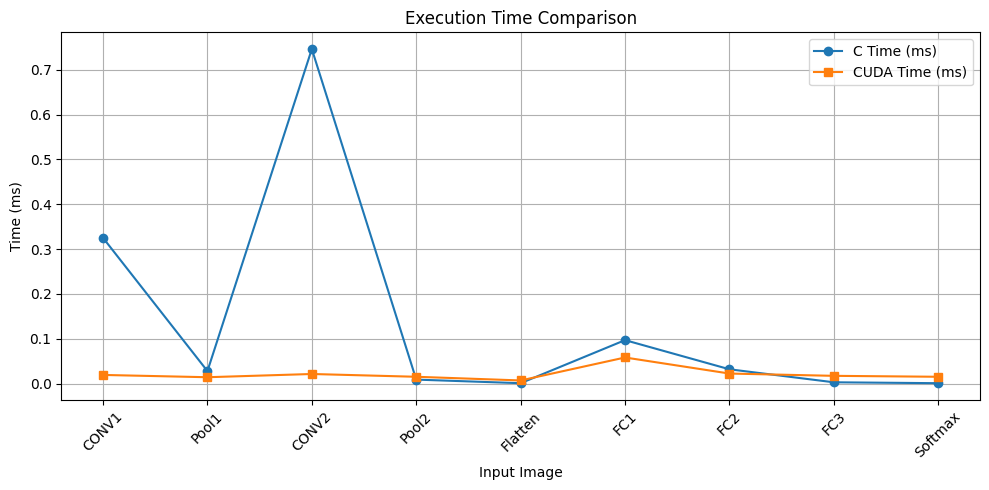

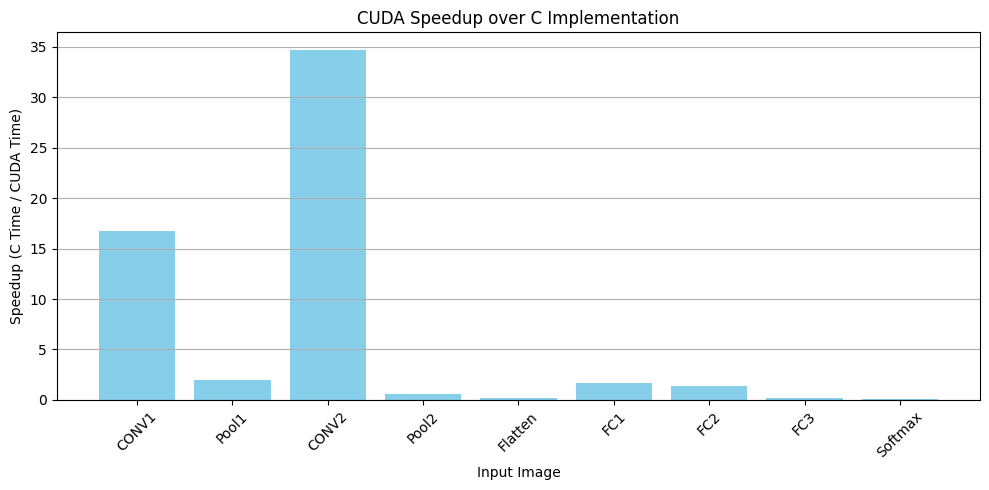

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
data = {
    "Image": ["CONV1", "Pool1", "CONV2", "Pool2", "Flatten", "FC1", "FC2", "FC3", "Softmax"],
    "C_Time": [0.325, 0.028, 0.746, 0.009, 0.001, 0.097, 0.032, 0.003, 0.001],
    "CUDA_Time": [0.0194, 0.0143, 0.0215, 0.0153, 0.0071, 0.0583, 0.0225, 0.0174, 0.0153],
}

# DataFrame and speedup calculation
df = pd.DataFrame(data)
df["Speedup"] = df["C_Time"] / df["CUDA_Time"]

# Plot 1: Execution time comparison
plt.figure(figsize=(10, 5))
plt.plot(df["Image"], df["C_Time"], marker='o', label='C Time (ms)')
plt.plot(df["Image"], df["CUDA_Time"], marker='s', label='CUDA Time (ms)')
plt.title("Execution Time Comparison")
plt.xlabel("Input Image")
plt.ylabel("Time (ms)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: CUDA Speedup
plt.figure(figsize=(10, 5))
plt.bar(df["Image"], df["Speedup"], color='skyblue')
plt.title("CUDA Speedup over C Implementation")
plt.xlabel("Input Image")
plt.ylabel("Speedup (C Time / CUDA Time)")
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()